In [1]:
import sys
sys.path.append("..") if ".." not in sys.path else print("Already exists")

import matplotlib.pyplot as plt
import seaborn as sns


import numpy as np
import pandas as pd
import PIL
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as F
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from torchvision import models
from torchvision import transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from utils.training import train_network, print_total_params
from utils import get_dataloader

### Load Dataset

In [2]:
df = pd.read_csv("../data/transformation_split.csv")

### Initiate Dataloaders

In [3]:
further_transforms = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [4]:
dataloader_train = get_dataloader(
    root_dir="../data/prepared_images/",
    df=df[df["set"] == "train"].drop_duplicates(),
    transformations=further_transforms,
    batch_size=32,
    workers=8, pin_memory=True
)
dataloader_val = get_dataloader(
    root_dir="../data/prepared_images/",
    df=df[df["set"] == "val"].drop_duplicates(),
    transformations=further_transforms,
    batch_size=32,
    workers=8, pin_memory=True
)
dataloader_test = get_dataloader(
    root_dir="../data/prepared_images/",
    df=df[df["set"] == "test"].drop_duplicates(),
    transformations=further_transforms,
    batch_size=32,
    workers=8, pin_memory=True
)

### Check Dataloader Batch

In [5]:
# Plot batch
batch = next(iter(dataloader_train))
batch, label = batch

In [6]:
plt.rcParams["savefig.bbox"] = "tight"


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(12, 20))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

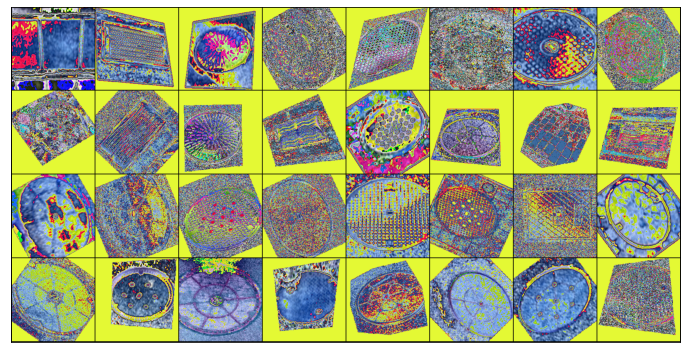

In [7]:
show(make_grid(batch, nrow=int(len(batch) / 4)))

# Model

In [8]:
convnext_tiny = models.convnext_tiny(pretrained=True, progress=True)

In [9]:
print(convnext_tiny)

ConvNeXt(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU()
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384

In [10]:
for param in convnext_tiny.parameters():
    param.requires_grad = False

convnext_tiny.classifier[2] = nn.Linear(
    in_features=768, out_features=len(dataloader_train.dataset.label_dict.keys())
)

for param in convnext_tiny.classifier.parameters():
    param.requires_grad = False
    print(param.requires_grad)
# Set requires grad for FC weights
convnext_tiny.classifier[2].weight.requires_grad = True

False
False
False
False


In [11]:
# Check
for name, param in convnext_tiny.named_parameters():
    if param.requires_grad:
        print(name)

classifier.2.weight


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(convnext_tiny.parameters(), lr=0.001)

In [ ]:
res = train_network(
    model=convnext_tiny,
    criterion=criterion,
    optimizer=optimizer_conv,
    n_epochs=10,
    dataloader_train=dataloader_train,
    dataloader_val=dataloader_val,
    verbose=True
)

  0%|          | 0/3210 [00:00<?, ?it/s]

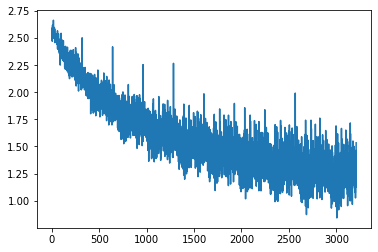

In [27]:
plt.plot(res[1]['train'])

In [ ]:
plt.plot(res[1])